In [1]:
import pandas as pd 
import numpy as np 
import torch 
import torchvision
import os 
import struct 
from torchvision import transforms 
from torch.utils.data import TensorDataset,DataLoader
import idx2numpy
import matplotlib.pyplot as plt 

In [2]:
train_array = idx2numpy.convert_from_file('../input/train-images-idx3-ubyte')
train_labels = idx2numpy.convert_from_file('../input/train-labels-idx1-ubyte')
test_array = idx2numpy.convert_from_file('../input/t10k-images-idx3-ubyte')
test_labels = idx2numpy.convert_from_file('../input/t10k-labels-idx1-ubyte')
print('Train Images Shape: ',train_array.shape)
print('Train Labels Shape: ',train_labels.shape)
print('Test Images Shape: ',test_array.shape)
print('Test Labels Shape: ',test_labels.shape)

Train Images Shape:  (60000, 28, 28)
Train Labels Shape:  (60000,)
Test Images Shape:  (10000, 28, 28)
Test Labels Shape:  (10000,)


In [3]:
image_array = train_array[:20]
labels_array = train_labels[:20]

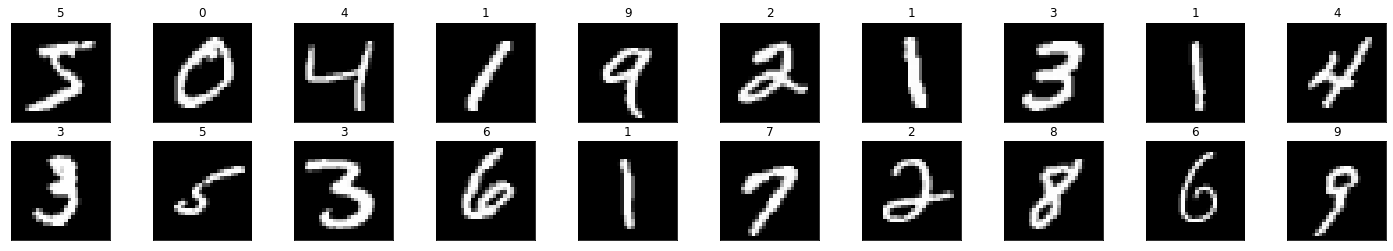

In [4]:
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    plt.imshow(image_array[idx].reshape(28,28),cmap='gray')
    ax.set_title(labels_array[idx])

In [5]:
from torch.utils.data.sampler import SubsetRandomSampler
valid_size = 0.2
num_train = len(train_array)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx,valid_idx = indices[split:],indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [6]:
train_array  = torch.tensor(train_array/255.0,dtype=torch.float)
train_labels  = torch.tensor(train_labels,dtype=torch.long)
test_array  = torch.tensor(test_array/255.0,dtype=torch.float)
test_labels  = torch.tensor(test_labels,dtype=torch.long)

train_dataset = TensorDataset(train_array,train_labels)
train_data = DataLoader(train_dataset,batch_size=20,sampler=train_sampler)
valid_data = DataLoader(train_dataset,batch_size=20,sampler=valid_sampler)

test_dataset = TensorDataset(test_array,test_labels)
test_data = DataLoader(test_dataset,batch_size=1)


In [7]:
import torch.nn as nn 
import torch.nn.functional as F

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,10)
        self.dropout = nn.Dropout(0.2)

    
    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x) 
        x = F.softmax(self.fc4(x))

        return x
model = Net()

In [9]:
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [10]:
import torch.optim as optim 

criterion = nn.CrossEntropyLoss()

optimizer  = optim.SGD(model.parameters(),lr = 0.01)

In [11]:
# Training the network 
# Number of epochs
epochs  = 30 
# Keeping track of validdation loss
valid_loss_min = np.Inf

for epoch in range(1,epochs+1):
    train_loss=0.0
    valid_loss = 0.0 
    ## Training the model
    ## Set the model in training_mode 
    model.train()
    for data,target in train_data: 
        # clear the gradients 
        optimizer.zero_grad()
        # fit the data in the model 
        output = model(data)
        # Compute the batch loss 
        loss= criterion(output,target)
        # backward pass: compute gradient of the loss with respect to model parameters 
        loss.backward()
        # perform a single optimization step(parameter update)
        optimizer.step()
        # updating the training_loss 
        train_loss += loss.item()*data.size(0)

    ## Validating the model 
    model.eval()
    for data,target in valid_data:
        output = model(data)
        loss = criterion(output,target)
        valid_loss += loss.item()*data.size(0)
    
    # Calculate the average loss
    train_loss = train_loss/len(train_data.sampler)
    valid_loss = valid_loss/len(valid_data.sampler)

    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch,train_loss,valid_loss))

    # save model if validation loss has decreased 
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min,valid_loss))
        torch.save(model.state_dict(),'../models/model_mnist_ann.pt')
        valid_loss_min=valid_loss


Epoch: 1 	Training Loss: 2.301946 	Validation Loss: 2.301032
Validation loss decreased (inf --> 2.301032). Saving model ...
Epoch: 2 	Training Loss: 2.300169 	Validation Loss: 2.298196
Validation loss decreased (2.301032 --> 2.298196). Saving model ...
Epoch: 3 	Training Loss: 2.295582 	Validation Loss: 2.289488
Validation loss decreased (2.298196 --> 2.289488). Saving model ...
Epoch: 4 	Training Loss: 2.259902 	Validation Loss: 2.162382
Validation loss decreased (2.289488 --> 2.162382). Saving model ...
Epoch: 5 	Training Loss: 2.025190 	Validation Loss: 1.892551
Validation loss decreased (2.162382 --> 1.892551). Saving model ...
Epoch: 6 	Training Loss: 1.849289 	Validation Loss: 1.768069
Validation loss decreased (1.892551 --> 1.768069). Saving model ...
Epoch: 7 	Training Loss: 1.778468 	Validation Loss: 1.738159
Validation loss decreased (1.768069 --> 1.738159). Saving model ...
Epoch: 8 	Training Loss: 1.752565 	Validation Loss: 1.725160
Validation loss decreased (1.738159 --> 1

In [12]:
model.load_state_dict(torch.load('../models/model_mnist_ann.pt'))

<All keys matched successfully>

In [13]:
test_loss = 0.0 
y_pred = []

model.eval()
for data,target in test_data:
    output =  model(data)
    loss = criterion(output,target)
    _,pred = torch.max(output,1)
    y_pred.append(pred)
    test_loss+=loss.item()*data.size(0)

test_loss = test_loss/len(test_data.sampler)

In [14]:
print('Test Loss: ',test_loss)

Test Loss:  1.5220016110539436


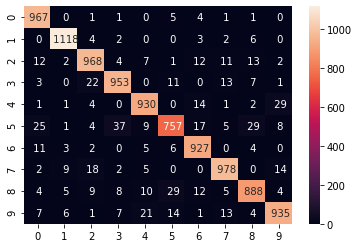

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_labels,y_pred)
ax = sns.heatmap(cm,annot=True,fmt=' ')

In [18]:
from sklearn.metrics import accuracy_score,classification_report
print(classification_report(test_labels,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       980
           1       0.98      0.99      0.98      1135
           2       0.94      0.94      0.94      1032
           3       0.94      0.94      0.94      1010
           4       0.94      0.95      0.94       982
           5       0.92      0.85      0.88       892
           6       0.94      0.97      0.95       958
           7       0.95      0.95      0.95      1028
           8       0.93      0.91      0.92       974
           9       0.94      0.93      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [17]:
len(test_labels)

10000